In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
os.getcwd()

'/Users/chance/Desktop/LH_home/ksc'

In [4]:
folder = os.listdir()

file = []
for f in folder:
    if "gajwa" in f:
        data = pd.read_csv("./" + f, encoding="cp949", skiprows=15)
        data = data[list(data.columns[:11])]
        file.append(data)

gajwa = pd.concat(file)
# gajwa = gajwa.dropna(axis=0)

In [5]:
gajwa.도로조건.value_counts()

12m미만    1297
-         851
8m미만      829
25m미만     146
25m이상      55
Name: 도로조건, dtype: int64

In [6]:
geo = pd.read_csv("./geocoding.csv")
gajwa["경도"] = geo.X
gajwa["위도"] = geo.Y

gajwa = gajwa.fillna({'건축년도':gajwa['건축년도'].mode()[0]})
gajwa = gajwa.fillna({'도로명':gajwa['도로명'].mode()[0]})
gajwa = gajwa.fillna({'도로조건':gajwa['도로조건'].mode()[0]})

# 도로조건을 정수로 변환
road=[]
for a in gajwa["도로조건"]:
    if a=="-":
        a = "8"
    if a=="25m이상":
        a = "30"
    road.append(int(a.split("m")[0]))
gajwa["도로조건"] = road


# 년월 column 생성
year=[]
month=[]
for d in gajwa["계약년월"]:
    day = pd.to_datetime(d, format="%Y%m")
    year.append(day.year)
    month.append(day.month)

gajwa["year"] = year
gajwa["month"] = month

built_day = [pd.to_datetime(d, format="%Y").year for d in gajwa["건축년도"]]
gajwa["건축년도"] = built_day

# 위치 column만들기
gajwa["location"] = gajwa.시군구 + " " + gajwa.도로명

# 계약년월 기준으로 전월세전환율 입력하기
rate = pd.read_csv("./rate.csv", encoding="cp949")
rate = rate.T
rate = rate[3:]

month = []
for r in rate.index:
    new = "".join(r.split("."))
    month.append(int(new))

rate["계약년월"] = month
rate.columns = ["전월세전환율", "계약년월"]
rate.head()

gajwa = pd.merge(left=gajwa, right=rate, how="inner", on="계약년월")

keep = [int("".join(k.split(","))) for k in gajwa["보증금(만원)"]]
gajwa["보증금(만원)"] = keep


# 전월세전환율 기준으로 보증금+월세의 가치를 전세로 치환하여 value column으로 만들어준다.
value=[round(gajwa["월세(만원)"][i] * 12 / (gajwa["전월세전환율"][i]/100) + gajwa["보증금(만원)"][i]) for i in range(len(gajwa))]
gajwa["전세전환가격"] = value
#gajwa["도로별 전세값평균"] = gajwa.groupby("도로명").전세전환가격.transform("mean")


# 도로명 결측치 제거
indexNames = []
for i in range(len(gajwa["도로명"])):
    if "번길" not in gajwa["도로명"][i]:
        indexNames.append(i)

gajwa.drop(indexNames, inplace=True)


gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735
3,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000
5,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,경상남도 진주시 가좌동,4**,12,30.00,월세,201807,19,500,43,2014,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,11250
3165,경상남도 진주시 가좌동,4**,12,35.20,월세,201807,12,800,50,2006,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,13300
3166,경상남도 진주시 가좌동,7**,12,40.86,전세,201807,11,5200,0,2007,진주대로671번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 진주대로671번길,4.8,5200
3167,경상남도 진주시 가좌동,4**,12,45.00,월세,201807,13,500,40,2007,가좌안골길14번길,128.109688,35.166125,2018,7,경상남도 진주시 가좌동 가좌안골길14번길,4.8,10500


## 지도

In [7]:
import math as m

def distance(x1, x2, y1, y2):
    radius = 6371 # 지구 반지름(km)
    toRadian = m.pi / 180

    deltaLatitude = abs(x1 - x2) * toRadian
    deltaLongitude = abs(y1 - y2) * toRadian

    sinDeltaLat = m.sin(deltaLatitude / 2)
    sinDeltaLng = m.sin(deltaLongitude / 2)
    squareRoot = m.sqrt(sinDeltaLat * sinDeltaLat + m.cos(x1 * toRadian) * m.cos(x2 * toRadian) * sinDeltaLng * sinDeltaLng)

    distance = 2 * radius * m.asin(squareRoot)

    return distance

In [8]:
gnu_lat = 35.1530444
gnu_long = 128.1010899

gnu_dist = []
for long, lat in zip(gajwa["경도"], gajwa["위도"]):
    d = distance(gnu_lat, lat, gnu_long, long)
    gnu_dist.append(d)
gajwa["gnu_distance"] = gnu_dist

## 데이터 시각화

In [9]:
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},)

In [10]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.7)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff

gajwa = remove_out(gajwa, ["계약면적(㎡)", "전세전환가격", "gnu_distance"])

gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,gnu_distance
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,경상남도 진주시 가좌동,4**,12,25.00,전세,201807,21,500,0,2008,개양로6번길,128.109160,35.157148,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,500,0.863971
2114,경상남도 진주시 가좌동,1***,8,26.00,월세,201807,7,300,39,1987,가좌길40번길,128.109160,35.157148,2018,7,경상남도 진주시 가좌동 가좌길40번길,4.8,10050,0.863971
2115,경상남도 진주시 가좌동,4**,12,30.00,월세,201807,19,500,43,2014,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,11250,0.434847
2116,경상남도 진주시 가좌동,4**,12,35.20,월세,201807,12,800,50,2006,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,13300,0.434847


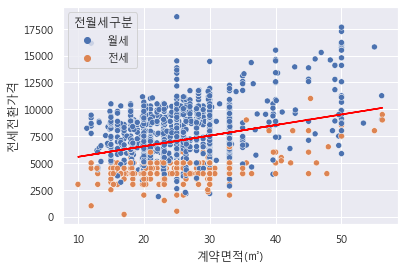

In [11]:
sns.scatterplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격", hue = "전월세구분")
# sns.lmplot(data = gajwa, x = "계약면적(㎡)", y = "전세전환가격")
m, b = np.polyfit(gajwa["계약면적(㎡)"] , gajwa["전세전환가격"], 1)
plt.plot(gajwa["계약면적(㎡)"], m * gajwa["계약면적(㎡)"] + b, color = "red")
plt.show()

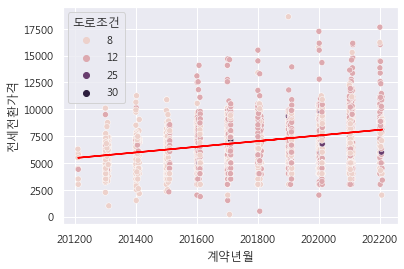

In [36]:
sns.scatterplot(data = gajwa, x = "계약년월", y = "전세전환가격", hue = "도로조건")
m, b = np.polyfit(gajwa["계약년월"] , gajwa["전세전환가격"], 1)
plt.plot(gajwa["계약년월"], m * gajwa["계약년월"] + b, color = "red")
plt.show()

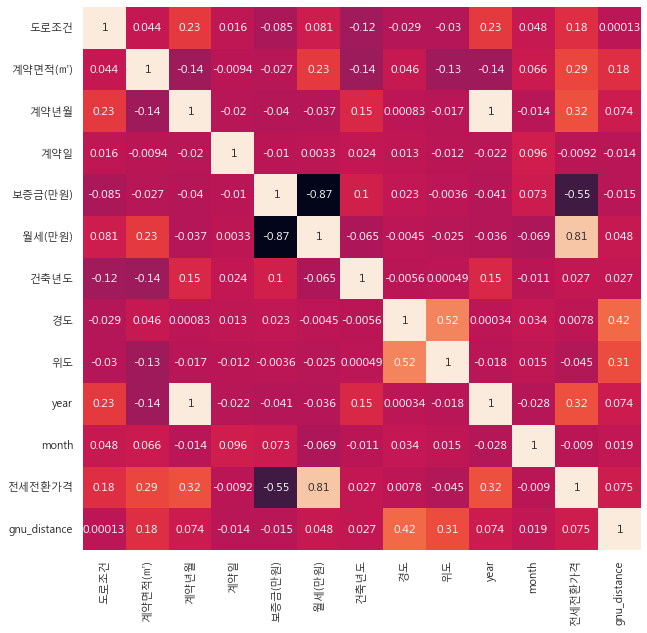

In [14]:
corr = gajwa.corr()

plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, cbar = False)
plt.show()

In [15]:
area = []

for long, lat in zip(gajwa["경도"],gajwa["위도"]) :
    if 128.102554 < long < 128.107094 and 35.155823 < lat < 35.162156 :
        area.append('후문')
    elif 128.107502 < long < 128.116019 and 35.155877 < lat < 35.158884 :
        area.append('경찰서')
    elif 128.105510 < long < 128.109887 and 35.152340 < lat <35.155835 :
        area.append('정문')
    elif 128.099328 < long < 128.105970 and 35.14718 < lat < 35.151686 :
        area.append('남문')
    elif 128.102356 < long < 128.118509 and 35.161807 < lat < 35.166844 :
        area.append('호탄')
    elif 128.107524 < long < 128.118378 and 35.159442 < lat < 35.161644 :
        area.append('호탄')
    else :
        area.append('그 외')

gajwa["area"] = area
gajwa

,시군구,번지,도로조건,계약면적(㎡),전월세구분,계약년월,계약일,보증금(만원),월세(만원),건축년도,도로명,경도,위도,year,month,location,전월세전환율,전세전환가격,gnu_distance,area
0,경상남도 진주시 가좌동,1***,25,12.00,월세,201902,16,200,35,2016,가좌길74번길,128.105889,35.157466,2019,2,경상남도 진주시 가좌동 가좌길74번길,5.1,8435,0.657356,후문
1,경상남도 진주시 가좌동,1***,12,14.85,월세,201902,20,500,35,2019,가좌길64번길,128.106121,35.158214,2019,2,경상남도 진주시 가좌동 가좌길64번길,5.1,8735,0.734594,후문
2,경상남도 진주시 가좌동,1***,8,16.00,전세,201902,20,3000,0,2016,가좌길48번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길48번길,5.1,3000,0.796668,후문
3,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,20,5000,0,2016,가좌길44번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 가좌길44번길,5.1,5000,0.796668,후문
4,경상남도 진주시 가좌동,1***,8,18.00,전세,201902,21,5000,0,2019,진주대로404번길,128.106188,35.158872,2019,2,경상남도 진주시 가좌동 진주대로404번길,5.1,5000,0.796668,후문
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,경상남도 진주시 가좌동,4**,12,25.00,전세,201807,21,500,0,2008,개양로6번길,128.109160,35.157148,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,500,0.863971,경찰서
2114,경상남도 진주시 가좌동,1***,8,26.00,월세,201807,7,300,39,1987,가좌길40번길,128.109160,35.157148,2018,7,경상남도 진주시 가좌동 가좌길40번길,4.8,10050,0.863971,경찰서
2115,경상남도 진주시 가좌동,4**,12,30.00,월세,201807,19,500,43,2014,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,11250,0.434847,남문
2116,경상남도 진주시 가좌동,4**,12,35.20,월세,201807,12,800,50,2006,개양로6번길,128.104882,35.150661,2018,7,경상남도 진주시 가좌동 개양로6번길,4.8,13300,0.434847,남문


In [16]:
# import folium

# m = folium.Map(location=[gnu_lat, gnu_long], zoom_start=14)

# for lo, la, in zip(gajwa.경도, gajwa.위도):
#     folium.Marker([la, lo]).add_to(m)

# m

In [17]:
# m = folium.Map(location=[gajwa.위도.max(),gajwa.경도.min()], zoom_start=16)
# folium.Marker([gajwa.위도.max(),gajwa.경도.min()]).add_to(m)
# m

In [18]:
# # 전세 월세 구분 데이터셋
# gajwa = gajwa[gajwa.전월세구분 == "월세"]
# gajwa = pd.DataFrame.drop(gajwa, columns=["전월세구분"], axis=1)

#원핫인코딩
gajwa = pd.get_dummies(gajwa, columns = ["전월세구분", "도로명"])


gajwa

,시군구,번지,도로조건,계약면적(㎡),계약년월,계약일,보증금(만원),월세(만원),건축년도,경도,...,도로명_내동로320번길,도로명_내동로348번길,도로명_진주대로404번길,도로명_진주대로500번길,도로명_진주대로516번길,도로명_진주대로542번길,도로명_진주대로568번길,도로명_진주대로647번길,도로명_진주대로671번길,도로명_진주역로96번길
0,경상남도 진주시 가좌동,1***,25,12.00,201902,16,200,35,2016,128.105889,...,0,0,0,0,0,0,0,0,0,0
1,경상남도 진주시 가좌동,1***,12,14.85,201902,20,500,35,2019,128.106121,...,0,0,0,0,0,0,0,0,0,0
2,경상남도 진주시 가좌동,1***,8,16.00,201902,20,3000,0,2016,128.106188,...,0,0,0,0,0,0,0,0,0,0
3,경상남도 진주시 가좌동,1***,8,18.00,201902,20,5000,0,2016,128.106188,...,0,0,0,0,0,0,0,0,0,0
4,경상남도 진주시 가좌동,1***,8,18.00,201902,21,5000,0,2019,128.106188,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,경상남도 진주시 가좌동,4**,12,25.00,201807,21,500,0,2008,128.109160,...,0,0,0,0,0,0,0,0,0,0
2114,경상남도 진주시 가좌동,1***,8,26.00,201807,7,300,39,1987,128.109160,...,0,0,0,0,0,0,0,0,0,0
2115,경상남도 진주시 가좌동,4**,12,30.00,201807,19,500,43,2014,128.104882,...,0,0,0,0,0,0,0,0,0,0
2116,경상남도 진주시 가좌동,4**,12,35.20,201807,12,800,50,2006,128.104882,...,0,0,0,0,0,0,0,0,0,0


In [19]:
gajwa_data = pd.DataFrame.drop(gajwa, columns=["시군구","계약년월", "번지", "계약일", "보증금(만원)", "월세(만원)", "location", "경도", "위도", "전월세전환율", "gnu_distance", "area"], axis=1)

#gajwa_data.distance = gajwa_data.distance.transform(lambda x: (x - x.mean()) / x.std())
#gajwa_data.전세전환가격 = gajwa_data.전세전환가격.transform(lambda x: (x - x.mean()) / x.std())
gajwa_data

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격,전월세구분_월세,전월세구분_전세,도로명_가좌길29번길,도로명_가좌길36번길,...,도로명_내동로320번길,도로명_내동로348번길,도로명_진주대로404번길,도로명_진주대로500번길,도로명_진주대로516번길,도로명_진주대로542번길,도로명_진주대로568번길,도로명_진주대로647번길,도로명_진주대로671번길,도로명_진주역로96번길
0,25,12.00,2016,2019,2,8435,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,14.85,2019,2019,2,8735,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,16.00,2016,2019,2,3000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,18.00,2016,2019,2,5000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,18.00,2019,2019,2,5000,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,12,25.00,2008,2018,7,500,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2114,8,26.00,1987,2018,7,10050,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2115,12,30.00,2014,2018,7,11250,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2116,12,35.20,2006,2018,7,13300,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 머신러닝

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import catboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

ModuleNotFoundError: No module named 'xgboost'

In [21]:
from sklearn.model_selection import train_test_split

X = gajwa_data.drop(["전세전환가격"], axis=1)
y = gajwa_data['전세전환가격']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1645)

# scaler = StandardScaler()
# X_train_standardized = scaler.fit_transform(X_train)
# X_test_standardized = scaler.fit_transform(X_test)

# minmaxScaler = MinMaxScaler()
# X_train_standardized2 = minmaxScaler.fit_transform(X_train)
# X_test_standardized2 = minmaxScaler.fit_transform(X_test)

## 선형회귀분석

In [22]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_preds = lr.predict(X_test)

# mse = mean_squared_error(y_test, y_preds)
# rmse = np.sqrt(mse)

# print(f"MSE : {mse:.3f}", f"RMSE: {rmse:.3f}")
# print(f"variance score : {r2_score(y_test, y_preds):.3f}")

In [23]:
# lr.fit(X_train_standardized, y_train)
# lr.score(X_test_standardized, y_test)

## Ridge

In [24]:
# R_model = Ridge()
# R_model.fit(X_train, y_train)
# print(R_model.score(X_test, y_test))

# R_model.fit(X_train_standardized, y_train)
# R_model.score(X_test_standardized, y_test)

## Lasso

In [25]:
# L_model = Lasso(alpha=0.5)
# L_model.fit(X_train, y_train)
# print(L_model.score(X_test, y_test))

# L_model.fit(X_train_standardized, y_train)
# L_model.score(X_test_standardized, y_test)

## ElasticNet

In [ ]:
# ela = ElasticNet(alpha=0.5)
# ela.fit(X_train, y_train)
# print(ela.score(X_test, y_test))

# ela.fit(X_train_standardized, y_train)
# ela.score(X_test_standardized, y_test)

## 랜덤포레스트

In [ ]:
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
randomforest_model = randomforest.fit(X_train, y_train)
print(randomforest_model.score(X_test, y_test))

0.7054843097878246


In [ ]:
# gbm = GradientBoostingRegressor()

# gbm.fit(X_train, y_train)
# print(gbm.score(X_test, y_test))

# gbm.fit(X_train_standardized, y_train)
# print(gbm.score(X_test_standardized, y_test))

## LightGBM

In [ ]:
lightgbm = lgb.LGBMRegressor()
lightgbm.fit(X_train, y_train)
y_pred = lightgbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

# lightgbm.fit(X_train_standardized, y_train)
# print(lightgbm.score(X_test_standardized, y_test))

0.7092141266736324

## XGBoost

In [ ]:
xgboost = XGBRegressor(n_estimators=50)
xgboost.fit(X_train, y_train)
print(xgboost.score(X_test, y_test))

# xgboost.fit(X_train_standardized, y_train)
# xgboost.score(X_test_standardized, y_test)

0.6995797911544364


/Users/chance/opt/anaconda3/envs/py3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



## CatBoost

In [ ]:
# cb = catboost.CatBoostRegressor()
# cb.fit(X_train_standardized, y_train)
# cb.score(X_test_standardized, y_test)

In [ ]:
gajwa_data.corr()

,도로조건,계약면적(㎡),건축년도,year,month,전세전환가격,전월세구분_월세,전월세구분_전세,도로명_가좌길29번길,도로명_가좌길36번길,...,도로명_내동로320번길,도로명_내동로348번길,도로명_진주대로404번길,도로명_진주대로500번길,도로명_진주대로516번길,도로명_진주대로542번길,도로명_진주대로568번길,도로명_진주대로647번길,도로명_진주대로671번길,도로명_진주역로96번길
도로조건,1.000000,0.044414,-0.115322,0.231303,0.047817,0.177561,0.036403,-0.036403,-0.122650,0.055011,...,-0.058103,0.091172,-0.147836,0.129256,0.021344,0.051200,0.073036,-0.077981,0.020399,0.026750
계약면적(㎡),0.044414,1.000000,-0.139511,-0.136555,0.066149,0.285899,0.095485,-0.095485,-0.012830,-0.134812,...,0.067961,0.103664,-0.027341,0.098899,-0.069752,0.071207,0.145685,0.053417,0.112882,0.042184
건축년도,-0.115322,-0.139511,1.000000,0.151122,-0.010770,0.027309,-0.094278,0.094278,0.051737,-0.074886,...,0.072525,-0.037747,0.005706,-0.054979,-0.030859,-0.002296,-0.017522,0.005600,-0.161244,0.052344
year,0.231303,-0.136555,0.151122,1.000000,-0.028102,0.318998,-0.023838,0.023838,-0.062626,0.111703,...,-0.000541,0.003591,-0.046555,-0.024249,-0.094461,-0.029125,-0.033680,-0.041476,0.003550,0.040929
month,0.047817,0.066149,-0.010770,-0.028102,1.000000,-0.008982,-0.045663,0.045663,0.026897,-0.017445,...,0.073956,0.013876,-0.032640,0.010036,0.031074,0.047377,0.065884,-0.003100,-0.019274,0.047858
전세전환가격,0.177561,0.285899,0.027309,0.318998,-0.008982,1.000000,0.622006,-0.622006,-0.000429,-0.020453,...,0.015789,0.087870,-0.251433,0.228485,-0.053176,0.047719,0.111837,0.007344,-0.003505,-0.031290
전월세구분_월세,0.036403,0.095485,-0.094278,-0.023838,-0.045663,0.622006,1.000000,-1.000000,0.026288,-0.038349,...,-0.013827,0.081552,-0.149864,0.167367,0.035304,0.052337,0.066023,0.049517,-0.039749,0.021594
전월세구분_전세,-0.036403,-0.095485,0.094278,0.023838,0.045663,-0.622006,-1.000000,1.000000,-0.026288,0.038349,...,0.013827,-0.081552,0.149864,-0.167367,-0.035304,-0.052337,-0.066023,-0.049517,0.039749,-0.021594
도로명_가좌길29번길,-0.122650,-0.012830,0.051737,-0.062626,0.026897,-0.000429,0.026288,-0.026288,1.000000,-0.044841,...,-0.017267,-0.023440,-0.082569,-0.057238,-0.010147,-0.026908,-0.028379,-0.017267,-0.008017,-0.006207
도로명_가좌길36번길,0.055011,-0.134812,-0.074886,0.111703,-0.017445,-0.020453,-0.038349,0.038349,-0.044841,1.000000,...,-0.028510,-0.038702,-0.136329,-0.094506,-0.016754,-0.044428,-0.046857,-0.028510,-0.013236,-0.010248


## HyperParameter

In [26]:
import optuna
from optuna.samplers import TPESampler

# random sampler
sampler = TPESampler(seed=10)

# define function
def objective(trial):

    param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        
        
    }

    # Generate model
    lgbm = lgb.LGBMRegressor(**param)
    lgbm = lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
                           verbose=0, early_stopping_rounds=25)

    # xgboost = XGBRegressor(n_estimators=50)
    # xgboost.fit(X_train, y_train)


    # * 평기 지표이다.
    # 원하는 평가 지표에 따라 사용하면 된다.                         
    # MSE = mean_squared_error(y_test, lgbm.predict(X_test))
    # return MSE
    rmse = mean_squared_error(y_test, lgbm.predict(X_test), squared=False)
    return rmse

    # r2 = r2_score(y_test, lgbm.predict(X_test)
    # return r2

study = optuna.create_study(direction='minimize', sampler=sampler)

# * n_trials의 경우 optuna를 몇번 실행하여 hyper parameter를 찾을 것인지를 정한다.
# 50으로 설정해도 유의미한 값이 나온다.
study.optimize(objective, n_trials=100)

ModuleNotFoundError: No module named 'optuna'

In [ ]:
optuna.visualization.plot_param_importances(study)

NameError: name 'optuna' is not defined

In [ ]:
trial = study.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

NameError: name 'study' is not defined

In [ ]:
final_model = lgb.LGBMRegressor(**trial_params)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2

NameError: name 'lgb' is not defined

0.67 : 도로조건	계약면적(㎡)	건축년도	year	month	전세전환가격	전월세구분_월세	전월세구분_전세
0.716 : 도로조건	계약면적(㎡)	건축년도	year	month	전세전환가격	전월세구분_월세	전월세구분_전세	도로명_가좌길29번길

## 딥러닝

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=38))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
model.fit(X_train, y_train, epochs=7000, batch_size=50)

Epoch 1/7000
34/34 [==============================] - 0s 1ms/step - loss: 42289304.0000 - mae: 5986.1084
Epoch 2/7000
34/34 [==============================] - 0s 1ms/step - loss: 8920509.0000 - mae: 2394.0422
Epoch 3/7000
34/34 [==============================] - 0s 1ms/step - loss: 5858371.0000 - mae: 1978.6490
Epoch 4/7000
34/34 [==============================] - 0s 806us/step - loss: 5794879.5000 - mae: 1974.4065
Epoch 5/7000
34/34 [==============================] - 0s 850us/step - loss: 5800833.0000 - mae: 1971.8427
Epoch 6/7000
34/34 [==============================] - 0s 880us/step - loss: 5748788.0000 - mae: 1966.8691
Epoch 7/7000
34/34 [==============================] - 0s 888us/step - loss: 5805632.5000 - mae: 1980.3481
Epoch 8/7000
34/34 [==============================] - 0s 855us/step - loss: 5784460.5000 - mae: 1975.8593
Epoch 9/7000
34/34 [==============================] - 0s 871us/step - loss: 5731536.5000 - mae: 1966.8049
Epoch 10/7000
34/34 [==============================

In [33]:
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
r2

0.5388510231160641